In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install PyWavelets

In [3]:
import os

# Path where training data is stored
train_data_path = "/content/drive/MyDrive/Dataset/splitset/"

# Get participant IDs from existing training files
train_participants = [
    file.split("_")[0] for file in os.listdir(train_data_path) if file.endswith("_train.mat")
]
train_participants = sorted(set(map(int, train_participants)))  # Ensure unique and sorted IDs

print("Loaded train participants:", train_participants)

Loaded train participants: [1, 2, 3, 6, 8, 10, 11, 12, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 29, 30, 31, 32, 33, 35, 36, 37, 39, 42, 43, 45, 46, 47, 48]


In [4]:
import numpy as np
import scipy.io
import pywt
import matplotlib.pyplot as plt
import joblib

sampling_rate = 256

# Define frequency bands
theta_band = (4, 8)
low_beta_band = (13, 20)
alpha_band = (8, 13)

# Specify the channels to use
selected_channels = [3, 5, 8, 14, 17, 19, 24, 25, 36, 39, 40, 45, 47, 52, 53]
selected_channels = [ch - 1 for ch in selected_channels]  # Convert to 0-based indexing

# Function to compute power using CWT
def compute_power_cwt(signal, scales, wavelet):
    coefficients, _ = pywt.cwt(signal, scales, wavelet, sampling_period=1.0/sampling_rate)
    return np.abs(coefficients) ** 2  # Power

# Initialize list to store features for the entire training set
all_theta_low_beta_alpha_features = []

# Loop through each participant
for participant in train_participants:
    # Load the .mat file for the participant
    train_file_path = f'/content/drive/MyDrive/Dataset/splitset/{int(participant)}_train.mat'
    data = scipy.io.loadmat(train_file_path)

    # Extract the EEG data (key is 'train_data' in the .mat file)
    participant_data = data['train_data']  # Shape: (timepoints, channels, trials)
    num_timepoints, num_channels, num_trials = participant_data.shape

    # Group trials into 20-second segments
    trial_duration = 1.5  # Duration of each trial in seconds
    segment_duration = 20  # Desired segment duration in seconds
    trials_per_segment = int(segment_duration / trial_duration)  # Number of trials per 20-second segment=13 trials

    # Extract 5-second windows from each 20-second segment
    window_duration = 5  # Duration of each window in seconds
    window_length = window_duration * sampling_rate  # Length of each window in samples
    overlap = 0.5  # 50% overlap between windows
    step_size = int(window_length * (1 - overlap))  # Step size for overlapping windows

    for start in range(0, num_trials - trials_per_segment + 1, trials_per_segment):
        # Extract 20-second segment for selected channels
        segment_data = participant_data[:, selected_channels, start:start + trials_per_segment]  # Shape: (timepoints, selected_channels, trials_per_segment)
        segment_signal = segment_data.reshape(-1, segment_data.shape[1])  # Flatten trials into a single time series

        # Ensure the segment is exactly 20 seconds
        segment_signal = segment_signal[:20 * sampling_rate, :]

        # Extract 5-second windows with overlap
        for i in range(0, len(segment_signal) - window_length + 1, step_size):
            window_signal = segment_signal[i:i + window_length, :]  # Shape: (window_length, selected_channels)

            # Compute theta/low-beta ratios for the window
            wavelet = 'cmor1.0-0.5'  # Complex Morlet wavelet

            # Compute scales using pywt.frequency2scale
            scales_theta = pywt.frequency2scale(wavelet, np.array(theta_band) / sampling_rate)
            scales_low_beta = pywt.frequency2scale(wavelet, np.array(low_beta_band) / sampling_rate)
            scales_alpha = pywt.frequency2scale(wavelet, np.array(alpha_band) / sampling_rate)

            window_TBAR = []

            for channel in range(len(selected_channels)):
                # Compute CWT for the channel
                theta_power = compute_power_cwt(window_signal[:, channel], scales_theta, wavelet).mean(axis=0)
                low_beta_power = compute_power_cwt(window_signal[:, channel], scales_low_beta, wavelet).mean(axis=0)
                alpha_power = compute_power_cwt(window_signal[:, channel], scales_alpha, wavelet).mean(axis=0)

                # Compute ratio
                TBAR = theta_power / (low_beta_power + alpha_power)

                window_TBAR.append(TBAR.mean())  # Average ratio over time

            # Aggregate features over channels
            all_theta_low_beta_alpha_features.append(np.mean(window_TBAR))

# Convert features to numpy array and reshape for clustering
all_theta_low_beta_alpha_features = np.array(all_theta_low_beta_alpha_features).reshape(-1, 1)

In [5]:
from sklearn.preprocessing import StandardScaler
import joblib

# Normalize the features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(all_theta_low_beta_alpha_features)

# Save the scaler for later use
scaler_path = "/content/drive/MyDrive/Dataset/clustering_models/DBSCAN_TLBAR_Scaler.pkl"
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to {scaler_path}")

Scaler saved to /content/drive/MyDrive/Dataset/clustering_models/DBSCAN_TLBAR_Scaler.pkl


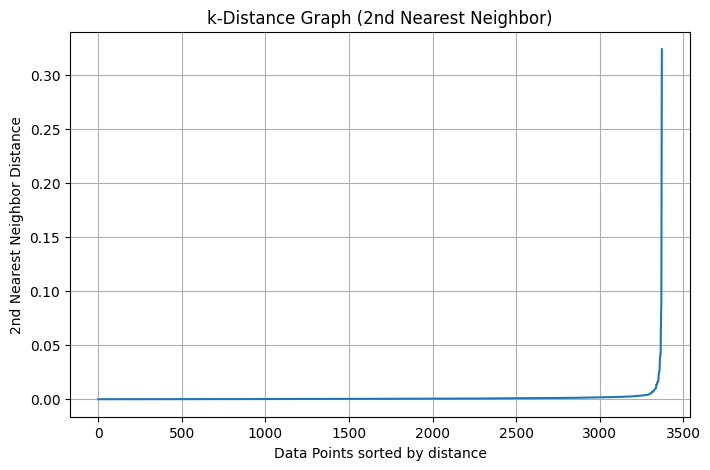

In [6]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(normalized_features)
distances, indices = neighbors_fit.kneighbors(normalized_features)

# Sort the distances to see the 'elbow'
sorted_distances = np.sort(distances[:, 1])
plt.figure(figsize=(8, 5))
plt.plot(sorted_distances)
plt.title('k-Distance Graph (2nd Nearest Neighbor)')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('2nd Nearest Neighbor Distance')
plt.grid(True)
plt.show()


The elbow appears around a 2nd nearest neighbor distance of approximately 0.035.

In [7]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.035, min_samples=2).fit(normalized_features)
labels = db.labels_

# Number of clusters (excluding noise)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f'Estimated number of clusters: {n_clusters}')
print(f'Estimated number of noise points: {n_noise}')


Estimated number of clusters: 14
Estimated number of noise points: 13


In [8]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np

# Use eps from elbow point
eps = 0.035
min_samples = 2

# Apply DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(normalized_features)

# Check for valid clustering (more than 1 cluster and not all noise)
if len(set(labels)) > 1 and not (len(set(labels)) == 1 + (1 if -1 in labels else 0)):
    sil_score = silhouette_score(normalized_features, labels)
    dbi_score = davies_bouldin_score(normalized_features, labels)
    print(f"Silhouette Score: {sil_score:.4f}")
    print(f"Davies-Bouldin Index: {dbi_score:.4f}")
else:
    sil_score = dbi_score = float('nan')
    print("Not enough clusters to compute Silhouette or DBI (all noise or one cluster).")


Silhouette Score: 0.2503
Davies-Bouldin Index: 2.3218


<ipython-input-9-2f6599f3d1a2>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


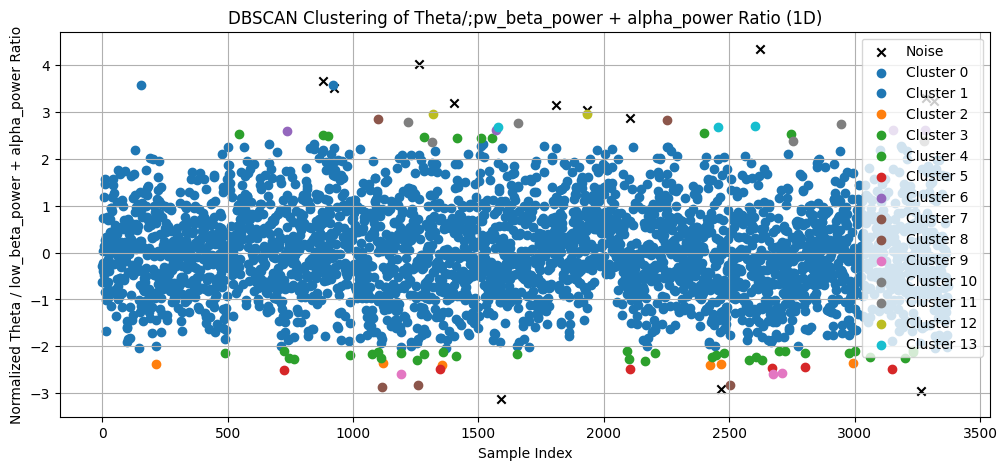

In [9]:
import matplotlib.pyplot as plt

# Create x-axis for plotting
x = np.arange(len(normalized_features))

plt.figure(figsize=(12, 5))
unique_labels = sorted(set(labels))
colors = plt.cm.get_cmap('tab10', len(unique_labels))

for label in unique_labels:
    cluster_mask = labels == label
    if label == -1:
        plt.scatter(x[cluster_mask], normalized_features[cluster_mask],
                    color='k', marker='x', label='Noise')
    else:
        plt.scatter(x[cluster_mask], normalized_features[cluster_mask],
                    color=colors(label), label=f'Cluster {label}')

plt.title('DBSCAN Clustering of Theta/;pw_beta_power + alpha_power Ratio (1D)')
plt.xlabel('Sample Index')
plt.ylabel('Normalized Theta / low_beta_power + alpha_power Ratio')
plt.legend()
plt.grid(True)
plt.show()
